In [ ]:
%env "WANDB_NOTEBOOK_NAME" "17_homo_attractor_no_strat.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.5

env: "WANDB_NOTEBOOK_NAME"="17_homo_attractor_no_strat.ipynb"
env: WANDB_SILENT=True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.5


In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle
import seaborn as sns

import os
import sys
import logging
from tqdm.notebook import trange
import wandb

from dysts.flows import Lorenz, Rossler


from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
input_size = 2
hidden_sizes = [100, 100] 
output_size = 1
initial_activation_list = [jax.nn.relu]
activation_list = [jax.nn.relu]
bias = True
num_epochs = 10000
add_node_every = 50
seed = 42
key = jax.random.PRNGKey(seed)
threshold = 1e-4
n_samples = 10000
learning_rate = 3e-4

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                seed=seed)

In [ ]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'add_node_every': add_node_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [ ]:
# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
Description = f"Homo_attractor_no_strat__no_bias_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{add_node_every}_{threshold}_{seed}"
fig_folder = f"../../figures/{Description}"
out_folder = f"../../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

In [ ]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 4
Description: Homo_attractor_no_strat__no_bias_100_100_10000_50_0.0001_42
Description: Homo_attractor_no_strat__no_bias_100_100_10000_50_0.0001_42
jax backend: gpu
jax backend: gpu
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]


In [ ]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
mlp = CustomMLP(config)

In [ ]:
# G, neuron_labels, neuron_importances = mlp.visualize_graph()
# fig = mlp_plot(G, neuron_labels, neuron_importances)
# plt.savefig(f"{fig_folder}/initial_graph.png")
# wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))

In [ ]:
model = Lorenz()
lorenz = model.make_trajectory(n_samples, resample=True)
# x = jnp.cos(jnp.linspace(0, 2 * jnp.pi, n_samples)).reshape(-1, 1)
# x = jnp.linspace(0, 2 * jnp.pi, n_samples).reshape(-1, 1)
# y = jnp.sin(jnp.linspace(0, 2 * jnp.pi, n_samples)).reshape(-1, 1)
x = jnp.array(lorenz[:, :-1])
y = jnp.array(lorenz[:, -1])
# x = jnp.arange(0, n_samples).reshape(-1, 1)
x_test = x[::10]
y_test = y[::10]

In [ ]:
x.shape, y.shape

((10000, 2), (10000,))

[<mpl_toolkits.mplot3d.art3d.Line3D>]

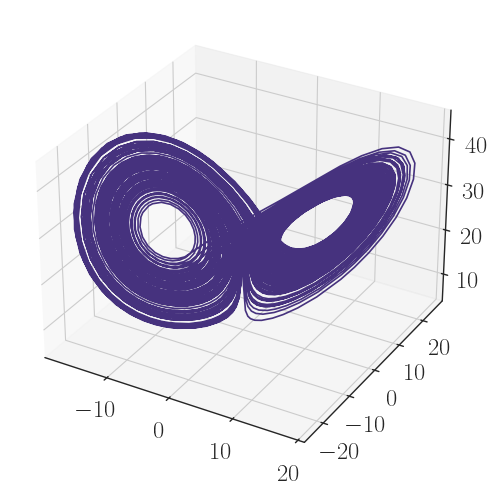

In [ ]:
plt.figure(figsize=(6,6)).add_subplot(projection='3d')
plt.plot(lorenz[:, 0], lorenz[:, 1], lorenz[:,2], label="3d attractor")

In [ ]:
opt = optax.adabelief(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

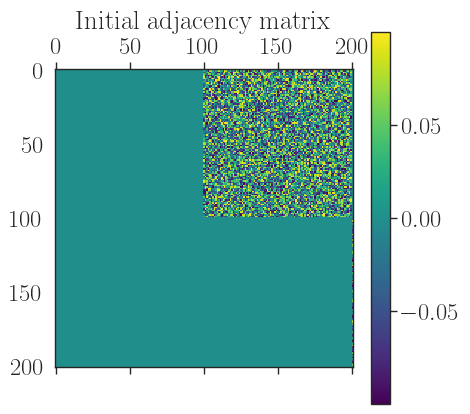

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

In [ ]:
Loss_history = []
Node_history = []
grad_norm_history = []
graph_history = []
Update_history = []

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    _, grads  = compute_loss(mlp, x, y)
    grad_norm_val = grad_norm(grads)
    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    logging.info(f"Epoch {epoch :03d}, Loss: {loss.item()}, Neurons: {n_neurons}, Grad norm: {grad_norm_val}")
    wandb.log({"loss": loss.item(), "neurons": n_neurons})
    Loss_history.append(loss)
    Node_history.append(n_neurons)
    grad_norm_history.append(grad_norm_val)
        
    if loss < threshold or grad_norm_val < 1e-6:
        # if loss is below threshold, stop training
        logging.info(f"Threshold reached, stopping training at epoch {epoch}")
        wandb.log({"threshold reached": epoch})
        break



Epoch 000, Loss: 646.7657242540422, Neurons: 201, Grad norm: 559.4539968050453
Epoch 000, Loss: 646.7657242540422, Neurons: 201, Grad norm: 559.4539968050453
Epoch 001, Loss: 639.1079995314267, Neurons: 201, Grad norm: 551.1557059095652
Epoch 001, Loss: 639.1079995314267, Neurons: 201, Grad norm: 551.1557059095652
Epoch 002, Loss: 631.2335060884872, Neurons: 201, Grad norm: 539.9286209925405
Epoch 002, Loss: 631.2335060884872, Neurons: 201, Grad norm: 539.9286209925405
Epoch 003, Loss: 623.2486184568021, Neurons: 201, Grad norm: 532.4379432054924
Epoch 003, Loss: 623.2486184568021, Neurons: 201, Grad norm: 532.4379432054924
Epoch 004, Loss: 615.199620517729, Neurons: 201, Grad norm: 526.673900635808
Epoch 004, Loss: 615.199620517729, Neurons: 201, Grad norm: 526.673900635808
Epoch 005, Loss: 607.0509886891508, Neurons: 201, Grad norm: 521.8081968333086
Epoch 005, Loss: 607.0509886891508, Neurons: 201, Grad norm: 521.8081968333086
Epoch 006, Loss: 598.7526198510062, Neurons: 201, Grad n

In [ ]:
np.savetxt(f"{out_folder}/neurons.txt", Node_history)
np.savetxt(f"{out_folder}/loss.txt", Loss_history)
np.savetxt(f"{out_folder}/grad_norm.txt", grad_norm_history)

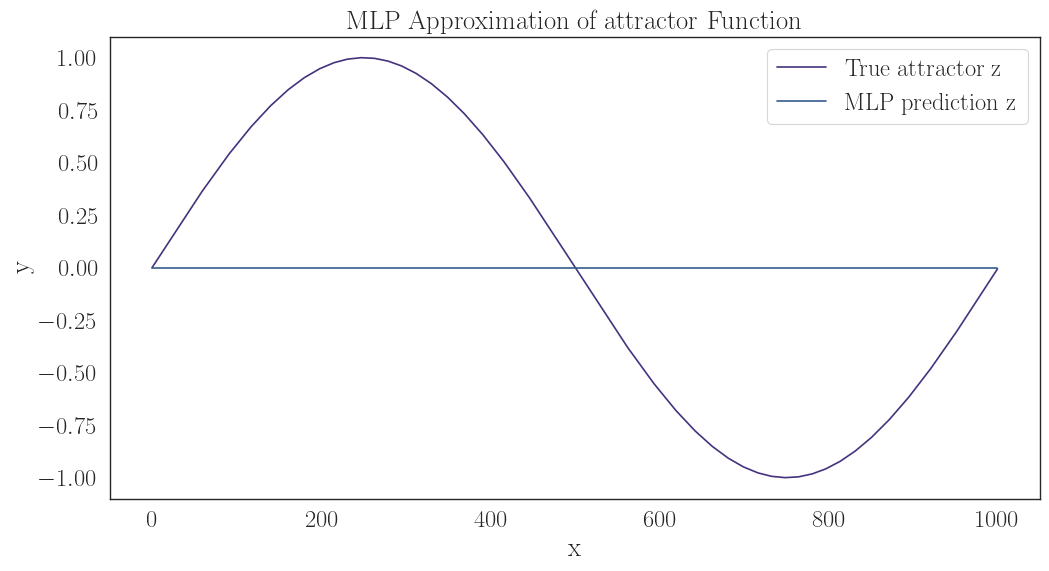

In [ ]:


y_pred = jax.vmap(mlp)(x_test)

plt.figure(figsize=(12,6))
plt.plot(y_test, label="True attractor z")
plt.plot(y_pred, label="MLP prediction z")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("MLP Approximation of attractor Function")
plt.savefig(f"{fig_folder}/attractor_approximation.png")
wandb.log({"attractor approximation": wandb.Image(plt, caption="attractor approximation")})


In [ ]:
Update_history

[]

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

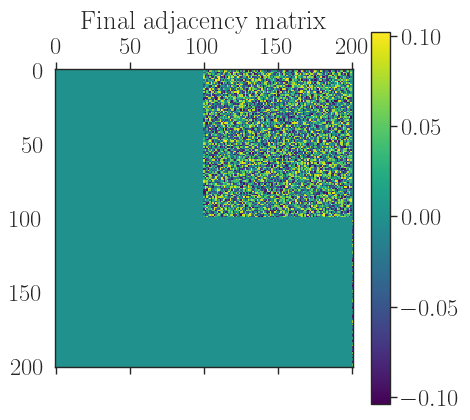

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

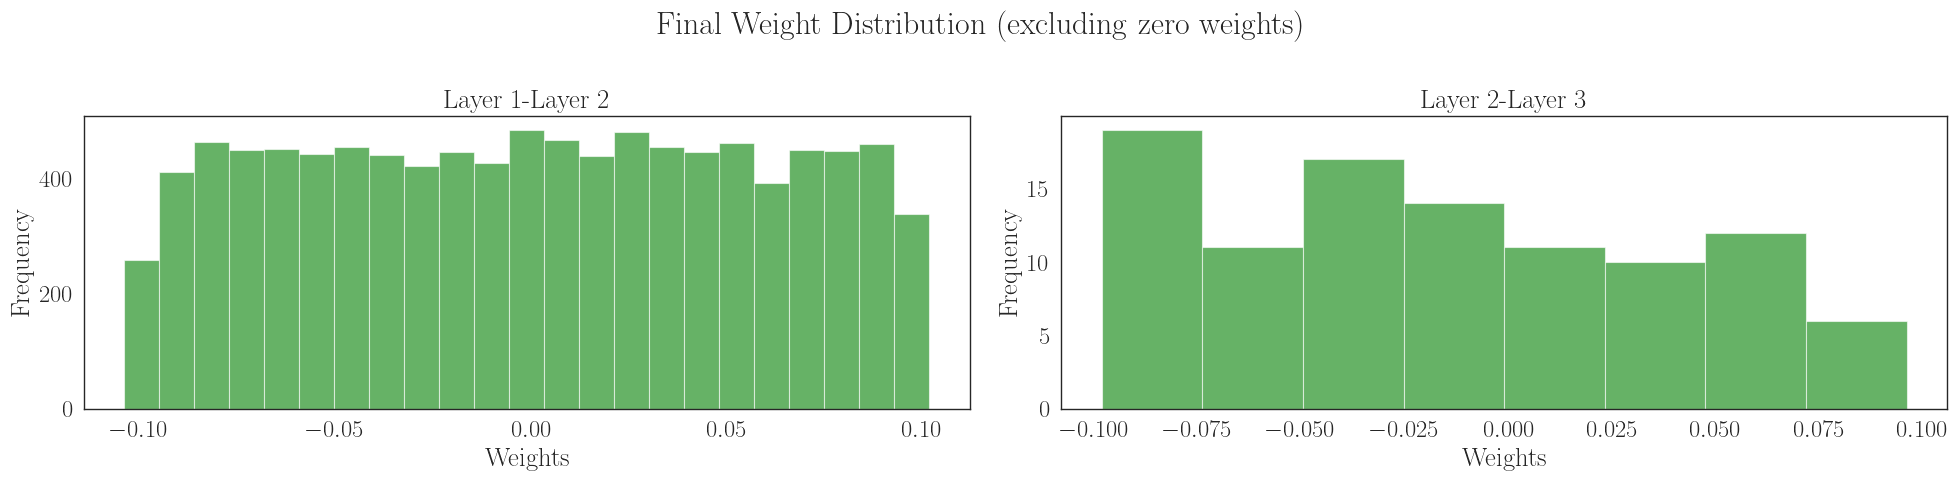

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum(mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

# Display the figure with its subplots
plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.show()

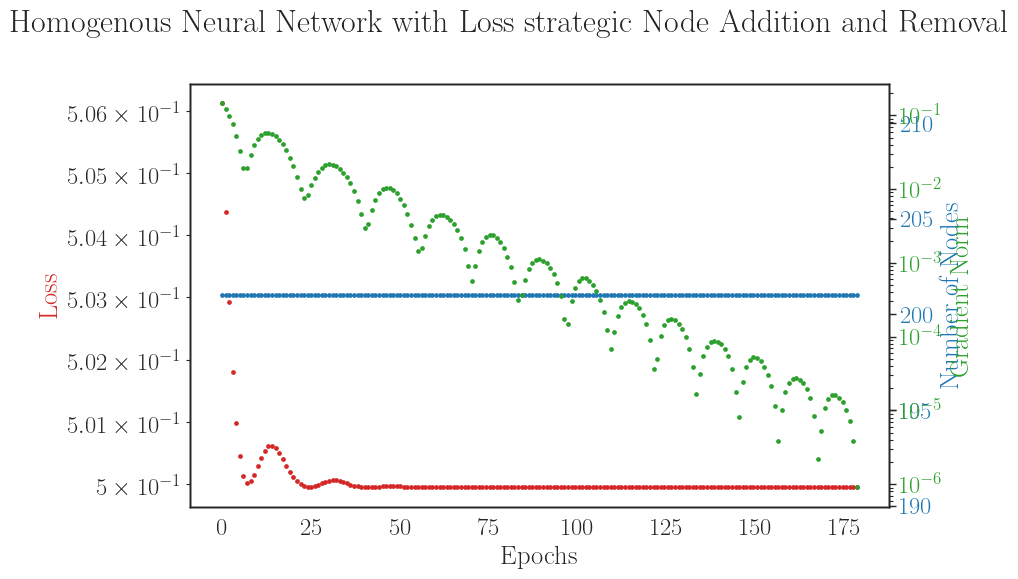

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a third axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('Gradient Norm', color=color)  # we already handled the x-label with ax1
ax3.plot(np.arange(0,len(grad_norm_history)), grad_norm_history, ".", color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")

plt.suptitle("Homogenous Neural Network with Loss strategic Node Addition and Removal")
fig.tight_layout()

plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

In [ ]:
# G, neuron_labels, neuron_importances = mlp.visualize_graph()
# fig = mlp_plot(G, neuron_labels, neuron_importances)
# plt.savefig(f"{fig_folder}/final_graph.png")
# wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [ ]:
wandb.finish()